In [1]:
import numpy as np
import random
import pandas as pd
from tqdm import tqdm 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import torchinfo

from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
def tnr_score(y_test, y_pred):
    y_t = np.array(y_test)
    y_p = np.array(y_pred)
    tn = np.sum((1-y_t)*(1-y_p))
    fp = np.sum(y_p*(1-y_t))
    if (tn + fp) == 0:
        return 0
    else:
        return tn / (tn + fp)

In [5]:
def split_train_test_val(data, target, test_size, val_size):
    nb_samples = len(target)
    nb_test = int(test_size * nb_samples)
    nb_val = int(val_size * nb_samples)

    shuffle = list(range(nb_samples))
    random.shuffle(shuffle)

    x_train, x_test, x_val, y_train, y_test, y_val = [], [], [], [], [], []
    
    nb_0_test = 0
    nb_1_test = 0
    nb_0_val = 0
    nb_1_val = 0

    for idx in shuffle:
        if nb_0_test < (nb_test//2) and target[idx]==0:
            y_test.append(0)
            x_test.append(data[idx])
            nb_0_test += 1
        elif nb_1_test < (nb_test//2) and target[idx]==1:
            y_test.append(1)
            x_test.append(data[idx])
            nb_1_test += 1
        elif nb_0_val < (nb_val//2) and target[idx]==0:
            y_val.append(0)
            x_val.append(data[idx])
            nb_0_val += 1
        elif nb_1_val < (nb_val//2) and target[idx]==1:
            y_val.append(1)
            x_val.append(data[idx])
            nb_1_val += 1
        else:
            y_train.append(target[idx])
            x_train.append(data[idx])
    
    return x_train, x_test, x_val, y_train, y_test, y_val


def prepareData(dataGroup, id_list, window_time):
    if dataGroup == "dataMimic":
        dataPath = "../Mimic/dataMimic/"
    elif dataGroup == "dataECMO":
        dataPath = "../dataECMO/"
    else:
        dataPath = "../dataRea/"

    finalDataPath = dataPath + "finalData/"

    data = []

    for encounterId in tqdm(id_list, total=len(id_list)):
        
        df_mask = pd.read_parquet(finalDataPath + encounterId + "/mask.parquet")
        df_dynamic = pd.read_parquet(finalDataPath + encounterId + "/dynamic.parquet")
        df_static = pd.read_parquet(finalDataPath + encounterId + "/static.parquet")
        
        # idx_variables_kept = [0,1,3,4,6,7]
        if dataGroup == "dataECMO":
            # idx_variables_kept = [0,1,2,3,4,5,6,7,8,9]
            idx_variables_kept = [0,1,2,3,4,5,6,7,8]
        else:
            idx_variables_kept = [0,1,2,3,4,5,6,7,8]

        data_patient = df_dynamic.iloc[:(window_time*24), idx_variables_kept].to_numpy()
        
        for value in df_static.to_numpy()[0]:
            new_column = np.ones(shape=(window_time*24,1)) * value
            data_patient = np.append(data_patient, new_column, axis=1)
        
        # df_dynamic_masked = df_dynamic.iloc[:(window_time*24)].mask(df_mask.iloc[:(window_time*24)] == 0)

        # # idx_variables_kept = [0,1,3,4,6,7]
        # idx_variables_kept = list(range(0,10))
        # df_dynamic_masked = df_dynamic_masked.iloc[:,idx_variables_kept]
        # df_dynamic = df_dynamic.iloc[:,idx_variables_kept]


        data.append(data_patient)
    
    return np.array(data)


def prepareDeathList(dataGroup, window_time, is_test_ECMO=False):
    target = []
    id_list = []
    
    if dataGroup == "dataMimic":
        dataPath = "../Mimic/dataMimic/"
        patients_df = pd.read_csv(dataPath + "ventiles.csv")

        nb_patients = len(patients_df)
    
        for index, row in tqdm(patients_df.iterrows(), total=nb_patients):
            stay_id = str(row["stay_id"])
            label_death = int(row["label"])
            id_list.append(stay_id)
            target.append(label_death)
        
        return target, id_list
    
    if dataGroup == "dataECMO":
        dataPath = "../dataECMO/"
    else:
        dataPath = "../dataRea/"
    
    patients_df = pd.read_parquet(dataPath + "patients.parquet")

    df_death = pd.read_csv(dataPath + "delais_deces.csv")
    
    nb_patients = len(patients_df)

    for _, row in tqdm(patients_df.iterrows(), total=nb_patients):
        encounterId = str(row["encounterId"])
        
        df_mask = pd.read_parquet(dataPath + "finalData/" + encounterId + "/mask.parquet")
        total_true_values = df_mask.values.sum()
        total_values = df_mask.values.size
        percentageMissingValues = (total_values-total_true_values)/total_values * 100
        
        withdrawal_date = pd.Timestamp(row["withdrawal_date"])
        installation_date = pd.Timestamp(row["installation_date"])
        total_time_hour = (withdrawal_date - installation_date).total_seconds() / 3600 + 4

        if total_time_hour >= window_time * 24 and percentageMissingValues < 40:
            if is_test_ECMO:
                if installation_date.year < 2020:
                    id_list.append(encounterId)
                
                    delai_sortie_deces = df_death.loc[df_death["encounterId"] == int(encounterId), "delai_sortie_deces"].to_numpy()[0]
                    if delai_sortie_deces <= 1:
                        target.append(1)
                    else:
                        target.append(0)
            else:
                id_list.append(encounterId)
                
                delai_sortie_deces = df_death.loc[df_death["encounterId"] == int(encounterId), "delai_sortie_deces"].to_numpy()[0]
                if delai_sortie_deces <= 1:
                    target.append(1)
                else:
                    target.append(0)
    
    return target, id_list

In [6]:
# dataGroup = "dataECMO"
# dataGroup = "dataRangueil"
dataGroup = "dataMimic"

window_time_days = 5
target, id_list = prepareDeathList(dataGroup, window_time_days)
data = prepareData(dataGroup, id_list, window_time_days)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4265/4265 [00:13<00:00, 316.36it/s]


In [14]:
class CNN_1D_0(nn.Module):
    def __init__(self, num_features, num_static_features):
        super(CNN_1D_0, self).__init__()
        
        self.num_features = num_features
        self.num_static_features = num_static_features

        self.conv1 = nn.Conv1d(in_channels=num_features-num_static_features, out_channels=8, kernel_size=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=1)
        self.fc1 = nn.Linear(480 , 4)
        self.fc2 = nn.Linear(4+num_static_features, 1)  

        self.dropout1 = nn.Dropout(p=0.5)

    def forward(self, x):
        cnn_input = x[:, :-self.num_static_features, :]
        static_input = x[:, -self.num_static_features:, 0]

        out = self.pool(nn.functional.relu(self.conv1(cnn_input)))
        out = self.pool(nn.functional.relu(self.conv2(out)))
        out = torch.flatten(out, 1)
        out = nn.functional.relu(self.fc1(out))
        out = torch.cat((out, static_input), dim=1)
        # out = self.dropout1(out)
        out = self.fc2(out)
        # out = torch.sigmoid(self.fc2(out))  
        return out
    
class CNN_1D_1(nn.Module):
    def __init__(self, num_features):
        super(CNN_1D_1, self).__init__()
        
        self.num_features = num_features

        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=16, kernel_size=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=1)
        self.fc1 = nn.Linear(960 , 32)
        self.fc2 = nn.Linear(32, 1)  

    def forward(self, x):

        out = self.pool(nn.functional.relu(self.conv1(x)))
        out = self.pool(nn.functional.relu(self.conv2(out)))
        out = torch.flatten(out, 1)
        out = nn.functional.relu(self.fc1(out))
        out = self.fc2(out)
        # out = torch.sigmoid(self.fc2(out))  
        return out
    
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(1, 3), padding=1)
        self.pool = nn.MaxPool2d(kernel_size=(2, 1))
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 3), padding=1)
        
        self.fc1 = nn.Linear(3224, 4) 
        self.fc2 = nn.Linear(4, 1)
        
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.75)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        # x = self.pool(nn.functional.relu(self.conv3(x)))
        # x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout2(x)
        # x = nn.functional.sigmoid(self.fc2(x))
        x = self.fc2(x)
        return x

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_static_features):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_static_features = num_static_features
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # self.fc1 = nn.Linear(hidden_size + num_static_features, 20)
        # self.fc2 = nn.Linear(20, output_size)
        self.fc2 = nn.Linear(hidden_size + num_static_features, 1)
    
    def forward(self, x):
        lstm_input = x[:, :, :-self.num_static_features]
        static_input = x[:, 0, -self.num_static_features:]

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(lstm_input, (h0, c0))
        out = out[:, -1, :]  # Take the output of the last time step

        out = torch.cat((out, static_input), dim=1)
        # out = torch.relu(self.fc1(out))

        # out = nn.functional.sigmoid(self.fc2(out))
        out = self.fc2(out)
        return out

class LSTMModel2(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_features_dynamic, num_features_static):
        
        super(LSTMModel2, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_features_dynamic = num_features_dynamic
        self.num_features_static = num_features_static
        
        # Create a list of LSTM layers, one for each feature
        self.lstms = nn.ModuleList([nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) for _ in range(num_features_dynamic)])
        
        # Linear layer for binary classification
        self.fc = nn.Linear(hidden_size*num_features_dynamic + num_features_static, output_size)
        
    def forward(self, x):
        
        lstm_outputs = []

        for i in range(self.num_features_dynamic):
            feature_input = x[:, :, i].unsqueeze(2)  # Shape: (batch_size, seq_length, 1)
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            lstm_out, _ = self.lstms[i](feature_input, (h0, c0))
            lstm_out = lstm_out[:, -1, :]  # Get the last time step output: Shape: (batch_size, hidden_size)
            lstm_outputs.append(lstm_out)
        
        # Concatenate the outputs from each LSTM
        out = torch.cat(lstm_outputs, dim=1)  # Shape: (batch_size, hidden_size * num_features)
        
        static_input = x[:, 0, -self.num_features_static:]
        out = torch.cat((out, static_input), dim=1)
        
        out = self.fc(out)
        # out = nn.functional.sigmoid(self.fc(out))  # Shape: (batch_size, output_size)
        
        return out

In [19]:
def train_model(data, target, num_epochs, model_name, test_size, val_size, verbose, save_path, save_model, plot_train_curves):
    
    # x_train, x_test, x_val, y_train, y_test, y_val = split_train_test_val(data, target, test_size=test_size, val_size=val_size)
    if test_size > 0:
        x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=test_size)
        while np.sum(y_test) < 2:
            x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=test_size)

        if val_size > 0:
            x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size)
            while np.sum(y_val) == 0:
                x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size)
        else:
            x_val = np.array([])
            y_val = np.array([])
    else:
        x_test = np.array([])
        y_test = np.array([])
        x_train, x_val, y_train, y_val = train_test_split(data, target, test_size=val_size)
        while np.sum(y_val) < 2:
            x_train, x_val, y_train, y_val = train_test_split(data, target, test_size=val_size)

    num_samples = len(target)
    num_timesteps = 24 * window_time_days
    num_features = np.size(x_train,2)
    num_features_static = 3
    num_features_dynamic = num_features - num_features_static

    
    batch_size = 32

    proportion_1 = np.sum(y_train)/np.size(y_train)
    proportion_0 = 1 - proportion_1

    class_weights = torch.tensor([1/proportion_0, 1/proportion_1], dtype=torch.float32)


    # Convert data to PyTorch tensors
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Create DataLoader for training and testing sets
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Instantiate the model
    if model_name == "CNN_1D_0":
        model = CNN_1D_0(num_features=num_features, num_static_features=num_features_static)

        # if verbose:
        #     print(torchinfo.summary(model, input_size=(batch_size, num_features, num_timesteps)))
    
    if model_name == "CNN_1D_1":
        model = CNN_1D_1(num_features=num_features)

    elif model_name == "CNN2":
            model = CNN2()

            if verbose:
                print(torchinfo.summary(model, input_size=(batch_size, num_timesteps, num_features)))

    elif model_name == "LSTM":
        input_size = num_features-num_features_static
        hidden_size = 32
        num_layers = 2
        output_size = 1

        model = LSTMModel(input_size, hidden_size, num_layers, output_size, num_features_static)

        if verbose:
            print(torchinfo.summary(model, input_size=(batch_size, num_timesteps, num_features)))

    if model_name == "LSTM2":
        input_size = 1
        hidden_size = 16
        num_layers = 1
        output_size = 1

        model = LSTMModel2(input_size, hidden_size, num_layers, output_size, num_features_dynamic, num_features_static)

        if verbose:
            print(torchinfo.summary(model, input_size=(batch_size, num_timesteps, num_features)))


    # criterion = nn.BCELoss()  # Binary cross-entropy loss

    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
    
    optimizer = optim.Adam(model.parameters())
    
    best_val_auroc = 0
    val_auroc_list = []
    train_auroc_list = []
    
    for epoch in range(num_epochs):
        
        model.train()
        running_loss = 0.0

        predictions = []
        true_labels = []
        # Training
        for inputs, labels in train_loader:
            optimizer.zero_grad()

            inputs = inputs.permute(0, 2, 1)
            
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            
            prediction = nn.functional.sigmoid(outputs).detach()
            predictions.extend(prediction.numpy())
            
            true_labels.extend(labels.numpy())

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_auroc = roc_auc_score(true_labels, predictions)
        train_auroc_list.append(train_auroc)

        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs}, Train loss: {running_loss:.4f}, Train AUROC: {train_auroc:.4f}")

        # Validation
        if np.size(y_val) > 0:
            model.eval()
            val_loss = 0.0

            predictions = []
            true_labels = []
            with torch.no_grad():
                for inputs, labels in val_loader:

                    inputs = inputs.permute(0, 2, 1)

                    outputs = model(inputs).squeeze()
                    val_loss += criterion(outputs, labels).item()

                    prediction = nn.functional.sigmoid(outputs)
                    predictions.extend(prediction.numpy())

                    true_labels.extend(labels.numpy())
        
            val_auroc = roc_auc_score(true_labels, predictions)
            val_auroc_list.append(val_auroc) 
            if verbose:
                print(f"Validation Loss: {val_loss:.4f}, Validation AUROC: {val_auroc:.4f}")

            if val_auroc > best_val_auroc:
                best_val_auroc = val_auroc
                train_auroc_at_best_val_auroc = train_auroc
                torch.save(model.state_dict(), save_path)
            

    if np.size(y_val) > 0:
        state_dict = torch.load(save_path)
        model.load_state_dict(state_dict)

        if plot_train_curves:
            plt.figure(figsize=(10, 6))

            plt.plot(range(num_epochs), train_auroc_list, label='Train AUROC', color='blue')
            plt.plot(range(num_epochs), val_auroc_list, label='Validation AUROC', color='red')

            plt.xlabel('epochs')
            plt.ylabel('auroc')
            plt.title('Train and Val AUROC = f(epoch)')

            plt.legend()

            plt.show()

    model.eval()

    true_labels = []
    predictions = []
    predictions_binary = []

    treshold = 0.5

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.permute(0, 2, 1)
            true_labels.extend(labels.numpy())

            outputs = nn.functional.sigmoid(model(inputs))
            predictions.extend(outputs.numpy())
            predictions_binary.extend((outputs.numpy() > treshold).astype(int))
            
            # print(np.round(np.array([p[0] for p in predictions]), 1))

    auroc = roc_auc_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions_binary, zero_division=0)
    recall = recall_score(true_labels, predictions_binary, zero_division=0)
    tnr = tnr_score(true_labels, predictions_binary)
    f1 = f1_score(true_labels, predictions_binary, zero_division=0)
    accuracy = accuracy_score(true_labels, predictions_binary)
    # if verbose:
    # print("Test AUROC score:", auroc)
    if train_auroc_at_best_val_auroc > best_val_auroc:
        return auroc, precision, recall, tnr, f1, accuracy, best_val_auroc, model.state_dict() 
    else:
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

  0%|                                                                                                                                                                      | 0/10 [00:00<?, ?it/s]

Epoch 1/25, Train loss: 53.4885, Train AUROC: 0.5747
Validation Loss: 7.0763, Validation AUROC: 0.6133
Epoch 2/25, Train loss: 50.0674, Train AUROC: 0.6967
Validation Loss: 6.7142, Validation AUROC: 0.6440
Epoch 3/25, Train loss: 47.8104, Train AUROC: 0.7348
Validation Loss: 6.8137, Validation AUROC: 0.6343
Epoch 4/25, Train loss: 46.3140, Train AUROC: 0.7547
Validation Loss: 7.0692, Validation AUROC: 0.6232
Epoch 5/25, Train loss: 45.3363, Train AUROC: 0.7648
Validation Loss: 7.3424, Validation AUROC: 0.6042
Epoch 6/25, Train loss: 44.2441, Train AUROC: 0.7805
Validation Loss: 7.5475, Validation AUROC: 0.6089
Epoch 7/25, Train loss: 43.2725, Train AUROC: 0.7931
Validation Loss: 7.3638, Validation AUROC: 0.6056
Epoch 8/25, Train loss: 41.7133, Train AUROC: 0.8142
Validation Loss: 7.6081, Validation AUROC: 0.5976
Epoch 9/25, Train loss: 39.9250, Train AUROC: 0.8299
Validation Loss: 7.4753, Validation AUROC: 0.5958
Epoch 10/25, Train loss: 39.6519, Train AUROC: 0.8332
Validation Loss: 7.

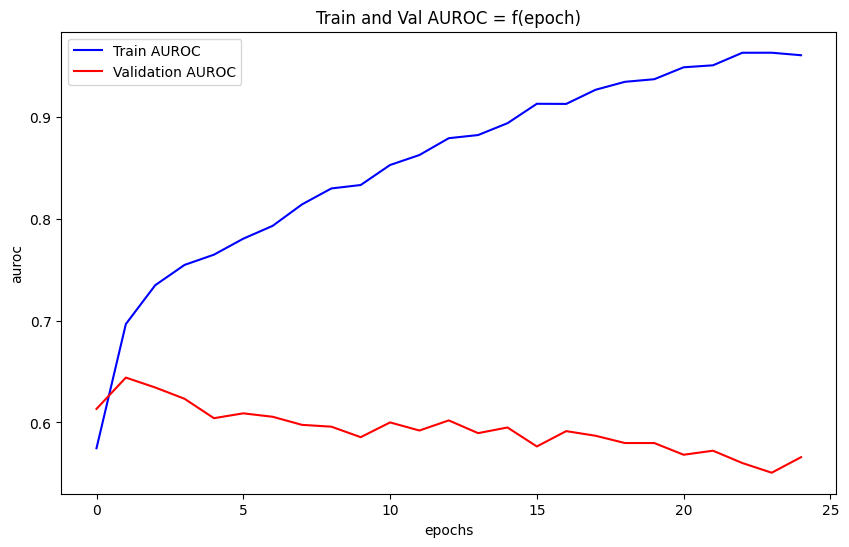

 10%|███████████████▊                                                                                                                                              | 1/10 [00:02<00:22,  2.51s/it]

New best val_auroc: 0.6440476190476191
Test AUROC with best model: 0.7158
Epoch 1/25, Train loss: 54.0742, Train AUROC: 0.5653
Validation Loss: 6.8558, Validation AUROC: 0.7802
Epoch 2/25, Train loss: 51.1260, Train AUROC: 0.6658
Validation Loss: 6.4552, Validation AUROC: 0.7834
Epoch 3/25, Train loss: 49.5679, Train AUROC: 0.7005
Validation Loss: 6.3596, Validation AUROC: 0.7875
Epoch 4/25, Train loss: 48.7795, Train AUROC: 0.7157
Validation Loss: 6.3174, Validation AUROC: 0.7681
Epoch 5/25, Train loss: 47.4532, Train AUROC: 0.7411
Validation Loss: 6.5785, Validation AUROC: 0.7601
Epoch 6/25, Train loss: 46.3026, Train AUROC: 0.7559
Validation Loss: 6.2553, Validation AUROC: 0.7657
Epoch 7/25, Train loss: 45.6610, Train AUROC: 0.7612
Validation Loss: 6.5888, Validation AUROC: 0.7752
Epoch 8/25, Train loss: 43.3342, Train AUROC: 0.7947
Validation Loss: 6.9607, Validation AUROC: 0.7659
Epoch 9/25, Train loss: 43.5680, Train AUROC: 0.7964
Validation Loss: 6.4886, Validation AUROC: 0.7675

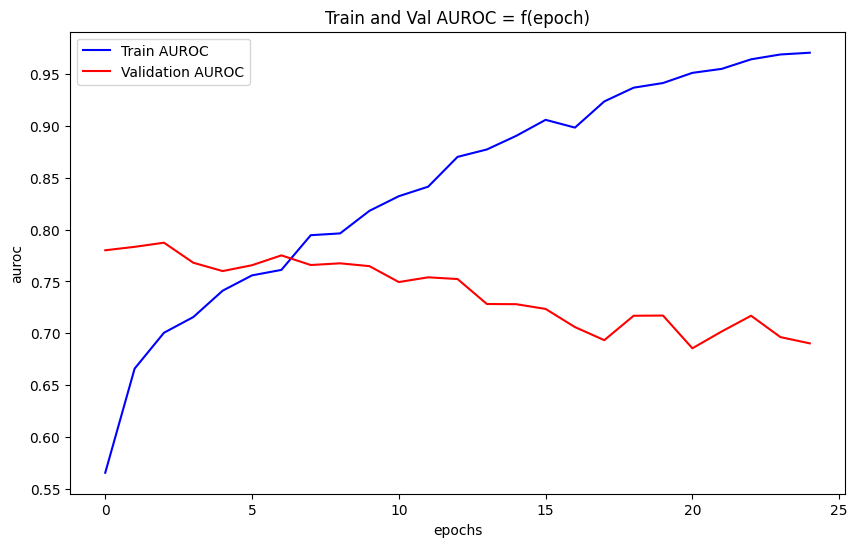

 20%|███████████████████████████████▌                                                                                                                              | 2/10 [00:05<00:20,  2.53s/it]

Test AUROC with best model: 0.7158
Epoch 1/25, Train loss: 54.0707, Train AUROC: 0.5789
Validation Loss: 7.4588, Validation AUROC: 0.6095
Epoch 2/25, Train loss: 51.4412, Train AUROC: 0.6808
Validation Loss: 7.3011, Validation AUROC: 0.6511
Epoch 3/25, Train loss: 48.8229, Train AUROC: 0.7258
Validation Loss: 7.2018, Validation AUROC: 0.6555
Epoch 4/25, Train loss: 47.5918, Train AUROC: 0.7416
Validation Loss: 7.6560, Validation AUROC: 0.6676
Epoch 5/25, Train loss: 45.7053, Train AUROC: 0.7699
Validation Loss: 7.4841, Validation AUROC: 0.6656
Epoch 6/25, Train loss: 44.2900, Train AUROC: 0.7876
Validation Loss: 7.9838, Validation AUROC: 0.6829
Epoch 7/25, Train loss: 42.8476, Train AUROC: 0.8068
Validation Loss: 7.5216, Validation AUROC: 0.6685
Epoch 8/25, Train loss: 42.9592, Train AUROC: 0.8044
Validation Loss: 8.2676, Validation AUROC: 0.6822
Epoch 9/25, Train loss: 40.3598, Train AUROC: 0.8325
Validation Loss: 7.7515, Validation AUROC: 0.6694
Epoch 10/25, Train loss: 38.9521, Trai

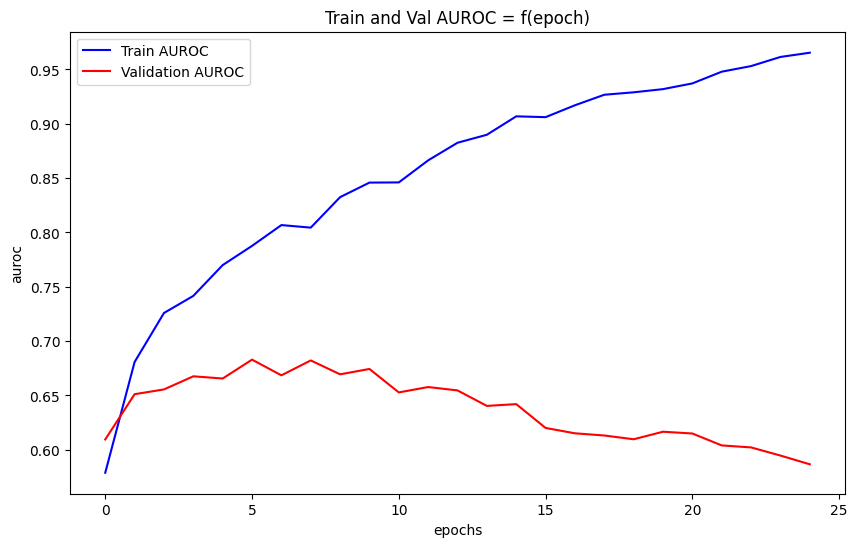

 30%|███████████████████████████████████████████████▍                                                                                                              | 3/10 [00:07<00:17,  2.53s/it]

New best val_auroc: 0.6829312865497076
Test AUROC with best model: 0.6840
Epoch 1/25, Train loss: 53.4078, Train AUROC: 0.5710
Validation Loss: 6.5390, Validation AUROC: 0.7777
Epoch 2/25, Train loss: 50.6535, Train AUROC: 0.6750
Validation Loss: 6.0493, Validation AUROC: 0.7791
Epoch 3/25, Train loss: 48.3742, Train AUROC: 0.7249
Validation Loss: 5.7886, Validation AUROC: 0.7787
Epoch 4/25, Train loss: 46.7901, Train AUROC: 0.7506
Validation Loss: 5.7220, Validation AUROC: 0.7826
Epoch 5/25, Train loss: 45.4974, Train AUROC: 0.7654
Validation Loss: 5.7077, Validation AUROC: 0.7643
Epoch 6/25, Train loss: 44.8836, Train AUROC: 0.7731
Validation Loss: 5.7627, Validation AUROC: 0.7737
Epoch 7/25, Train loss: 42.9716, Train AUROC: 0.7994
Validation Loss: 5.9198, Validation AUROC: 0.7777
Epoch 8/25, Train loss: 42.3709, Train AUROC: 0.8094
Validation Loss: 5.8557, Validation AUROC: 0.7648
Epoch 9/25, Train loss: 40.6655, Train AUROC: 0.8247
Validation Loss: 5.9431, Validation AUROC: 0.7608

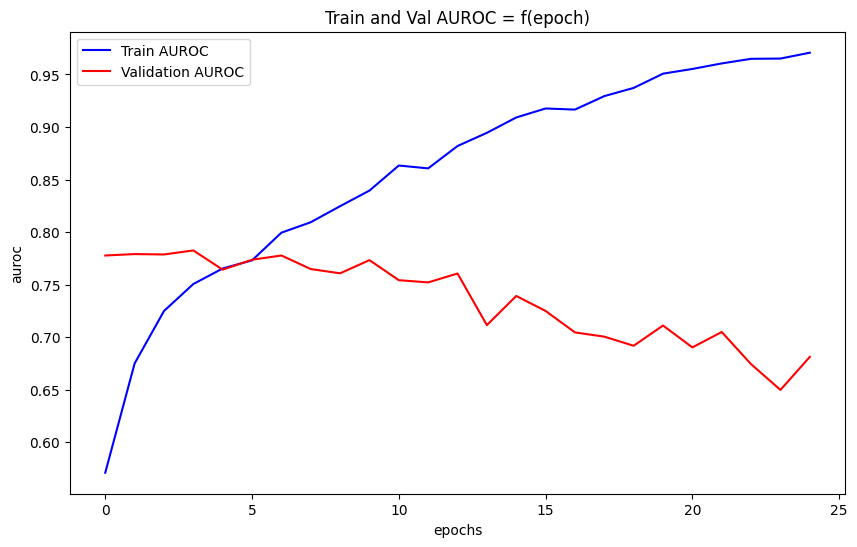

 40%|███████████████████████████████████████████████████████████████▏                                                                                              | 4/10 [00:10<00:15,  2.54s/it]

Test AUROC with best model: 0.6840
Epoch 1/25, Train loss: 51.6924, Train AUROC: 0.6410
Validation Loss: 6.3362, Validation AUROC: 0.6168
Epoch 2/25, Train loss: 48.4898, Train AUROC: 0.7206
Validation Loss: 6.3972, Validation AUROC: 0.6189
Epoch 3/25, Train loss: 46.6988, Train AUROC: 0.7457
Validation Loss: 6.2260, Validation AUROC: 0.6215
Epoch 4/25, Train loss: 45.7199, Train AUROC: 0.7580
Validation Loss: 6.7058, Validation AUROC: 0.6172
Epoch 5/25, Train loss: 45.6802, Train AUROC: 0.7583
Validation Loss: 6.4015, Validation AUROC: 0.6213
Epoch 6/25, Train loss: 44.0003, Train AUROC: 0.7802
Validation Loss: 6.2938, Validation AUROC: 0.6279
Epoch 7/25, Train loss: 42.3910, Train AUROC: 0.8032
Validation Loss: 6.3602, Validation AUROC: 0.6285
Epoch 8/25, Train loss: 41.0110, Train AUROC: 0.8172
Validation Loss: 6.3955, Validation AUROC: 0.6314
Epoch 9/25, Train loss: 39.2204, Train AUROC: 0.8350
Validation Loss: 6.5514, Validation AUROC: 0.6281
Epoch 10/25, Train loss: 38.4779, Trai

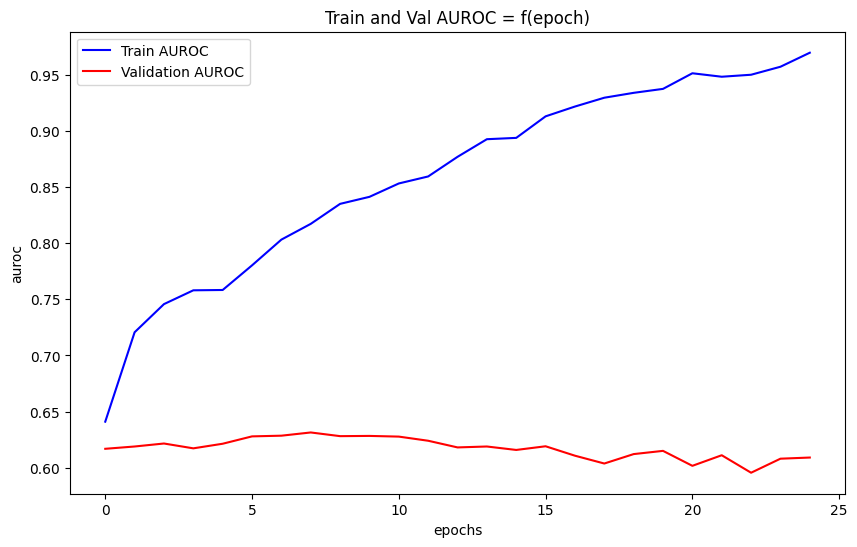

 50%|███████████████████████████████████████████████████████████████████████████████                                                                               | 5/10 [00:12<00:12,  2.54s/it]

Test AUROC with best model: 0.6840
Epoch 1/25, Train loss: 52.7165, Train AUROC: 0.6180
Validation Loss: 7.4132, Validation AUROC: 0.5938
Epoch 2/25, Train loss: 49.5484, Train AUROC: 0.6974
Validation Loss: 7.5235, Validation AUROC: 0.5951
Epoch 3/25, Train loss: 48.0292, Train AUROC: 0.7239
Validation Loss: 7.3206, Validation AUROC: 0.6010
Epoch 4/25, Train loss: 46.7894, Train AUROC: 0.7510
Validation Loss: 7.0737, Validation AUROC: 0.6454
Epoch 5/25, Train loss: 45.3404, Train AUROC: 0.7652
Validation Loss: 7.0710, Validation AUROC: 0.6564
Epoch 6/25, Train loss: 44.4170, Train AUROC: 0.7775
Validation Loss: 7.0562, Validation AUROC: 0.6630
Epoch 7/25, Train loss: 43.6679, Train AUROC: 0.7864
Validation Loss: 6.7177, Validation AUROC: 0.6687
Epoch 8/25, Train loss: 42.0341, Train AUROC: 0.8053
Validation Loss: 6.8468, Validation AUROC: 0.6679
Epoch 9/25, Train loss: 42.3263, Train AUROC: 0.8046
Validation Loss: 7.9244, Validation AUROC: 0.6520
Epoch 10/25, Train loss: 39.8024, Trai

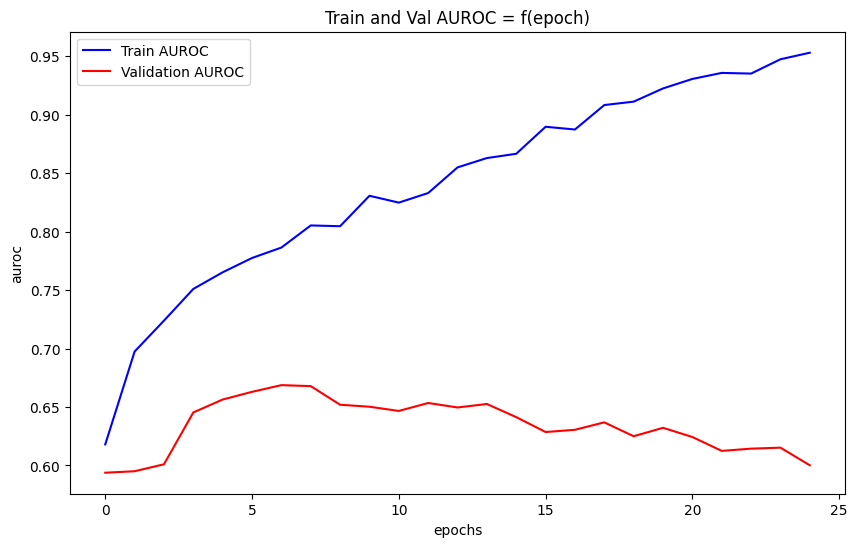

 60%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 6/10 [00:15<00:10,  2.54s/it]

Test AUROC with best model: 0.6840
Epoch 1/25, Train loss: 52.9847, Train AUROC: 0.5894
Validation Loss: 6.2242, Validation AUROC: 0.7237
Epoch 2/25, Train loss: 50.1990, Train AUROC: 0.6768
Validation Loss: 6.1672, Validation AUROC: 0.7398
Epoch 3/25, Train loss: 48.8732, Train AUROC: 0.7064
Validation Loss: 5.9286, Validation AUROC: 0.7470
Epoch 4/25, Train loss: 46.7689, Train AUROC: 0.7445
Validation Loss: 5.5993, Validation AUROC: 0.7600
Epoch 5/25, Train loss: 45.6882, Train AUROC: 0.7580
Validation Loss: 5.5913, Validation AUROC: 0.7589
Epoch 6/25, Train loss: 44.4806, Train AUROC: 0.7798
Validation Loss: 5.6086, Validation AUROC: 0.7562
Epoch 7/25, Train loss: 43.6951, Train AUROC: 0.7867
Validation Loss: 5.6178, Validation AUROC: 0.7494
Epoch 8/25, Train loss: 41.7886, Train AUROC: 0.8151
Validation Loss: 5.8099, Validation AUROC: 0.7351
Epoch 9/25, Train loss: 40.4279, Train AUROC: 0.8239
Validation Loss: 5.7266, Validation AUROC: 0.7345
Epoch 10/25, Train loss: 39.1864, Trai

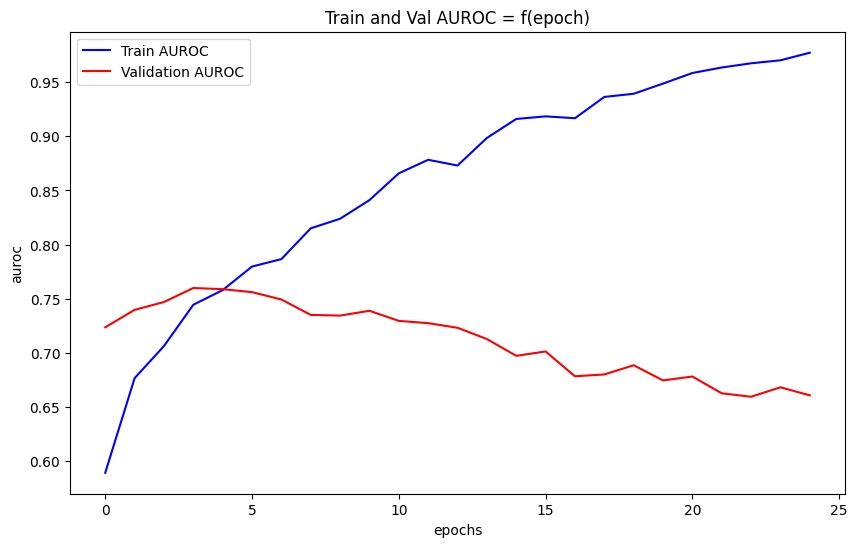

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 7/10 [00:17<00:07,  2.55s/it]

Test AUROC with best model: 0.6840
Epoch 1/25, Train loss: 53.4597, Train AUROC: 0.5764
Validation Loss: 6.8332, Validation AUROC: 0.5682
Epoch 2/25, Train loss: 50.3928, Train AUROC: 0.6879
Validation Loss: 6.2822, Validation AUROC: 0.6357
Epoch 3/25, Train loss: 47.8865, Train AUROC: 0.7245
Validation Loss: 6.1938, Validation AUROC: 0.6826
Epoch 4/25, Train loss: 46.1244, Train AUROC: 0.7555
Validation Loss: 6.0122, Validation AUROC: 0.6958
Epoch 5/25, Train loss: 45.2617, Train AUROC: 0.7689
Validation Loss: 6.0377, Validation AUROC: 0.7139
Epoch 6/25, Train loss: 44.3970, Train AUROC: 0.7763
Validation Loss: 5.6715, Validation AUROC: 0.7263
Epoch 7/25, Train loss: 42.9416, Train AUROC: 0.7974
Validation Loss: 5.7404, Validation AUROC: 0.7036
Epoch 8/25, Train loss: 42.4914, Train AUROC: 0.7987
Validation Loss: 5.7144, Validation AUROC: 0.7165
Epoch 9/25, Train loss: 41.3945, Train AUROC: 0.8141
Validation Loss: 5.9562, Validation AUROC: 0.7088
Epoch 10/25, Train loss: 40.6802, Trai

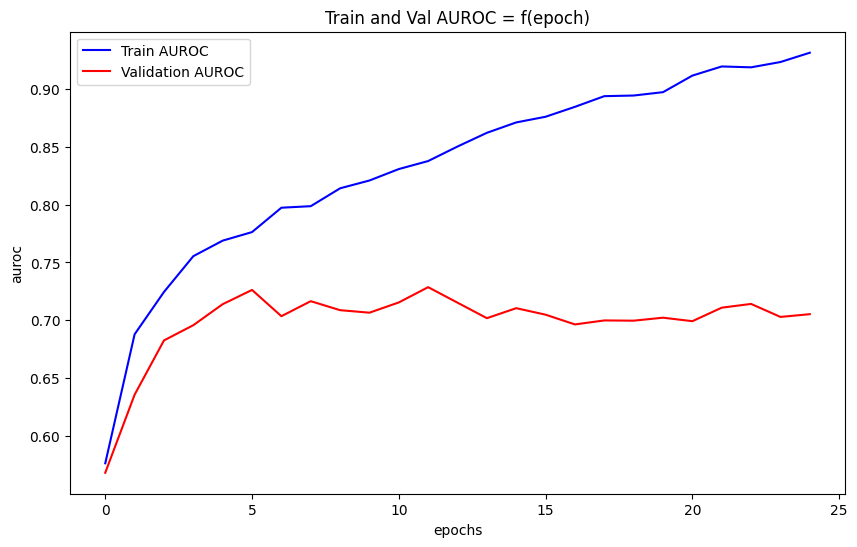

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 8/10 [00:20<00:05,  2.54s/it]

New best val_auroc: 0.7286486486486486
Test AUROC with best model: 0.7613
Epoch 1/25, Train loss: 53.9250, Train AUROC: 0.5465
Validation Loss: 6.0468, Validation AUROC: 0.7422
Epoch 2/25, Train loss: 51.1793, Train AUROC: 0.6599
Validation Loss: 5.5442, Validation AUROC: 0.7510
Epoch 3/25, Train loss: 49.6775, Train AUROC: 0.6918
Validation Loss: 5.4394, Validation AUROC: 0.7575
Epoch 4/25, Train loss: 47.6890, Train AUROC: 0.7345
Validation Loss: 5.3367, Validation AUROC: 0.7552
Epoch 5/25, Train loss: 46.7367, Train AUROC: 0.7539
Validation Loss: 5.1372, Validation AUROC: 0.7609
Epoch 6/25, Train loss: 45.1157, Train AUROC: 0.7741
Validation Loss: 5.9551, Validation AUROC: 0.7280
Epoch 7/25, Train loss: 44.1598, Train AUROC: 0.7827
Validation Loss: 5.6038, Validation AUROC: 0.7332
Epoch 8/25, Train loss: 43.2573, Train AUROC: 0.7937
Validation Loss: 6.0733, Validation AUROC: 0.7269
Epoch 9/25, Train loss: 41.4587, Train AUROC: 0.8160
Validation Loss: 5.5850, Validation AUROC: 0.7384

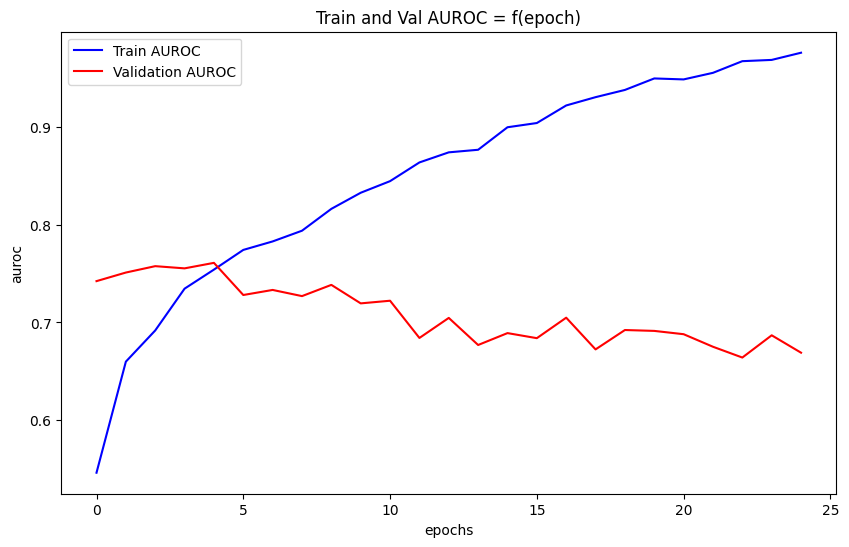

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 9/10 [00:22<00:02,  2.55s/it]

Test AUROC with best model: 0.7613
Epoch 1/25, Train loss: 52.8776, Train AUROC: 0.6122
Validation Loss: 6.6806, Validation AUROC: 0.6932
Epoch 2/25, Train loss: 49.6039, Train AUROC: 0.7040
Validation Loss: 6.6306, Validation AUROC: 0.7329
Epoch 3/25, Train loss: 48.1302, Train AUROC: 0.7275
Validation Loss: 6.4806, Validation AUROC: 0.7393
Epoch 4/25, Train loss: 47.2552, Train AUROC: 0.7362
Validation Loss: 6.6098, Validation AUROC: 0.7361
Epoch 5/25, Train loss: 45.7564, Train AUROC: 0.7645
Validation Loss: 6.5476, Validation AUROC: 0.7262
Epoch 6/25, Train loss: 44.8247, Train AUROC: 0.7708
Validation Loss: 6.5929, Validation AUROC: 0.7264
Epoch 7/25, Train loss: 44.2578, Train AUROC: 0.7892
Validation Loss: 7.0506, Validation AUROC: 0.7341
Epoch 8/25, Train loss: 43.2903, Train AUROC: 0.7941
Validation Loss: 6.6878, Validation AUROC: 0.7219
Epoch 9/25, Train loss: 41.6267, Train AUROC: 0.8136
Validation Loss: 6.7029, Validation AUROC: 0.7150
Epoch 10/25, Train loss: 40.9697, Trai

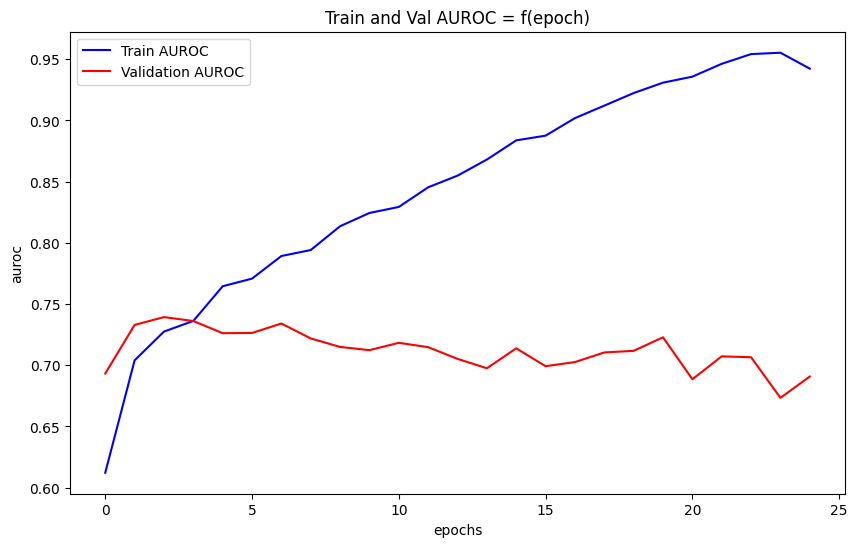

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.54s/it]

Test AUROC with best model: 0.7613
AUROC: 0.7613
Precision: 0.3908
Recall: 0.7907
Specificity: 0.5167
Accuracy: 0.6556
F1 Score: 0.5231
num_algos: 1


In [23]:
num_train = 10

save_path = "LSTMs/lstm0.pth"

aurocs = []
precisions = []
recalls = []
tnrs = []
accuracies = []
f1s = []

best_val_auroc_all_models = 0
best_model_state_dict = 0
for i in tqdm(range(num_train), total=num_train):
    
    # auroc = train_model(num_epochs=15, model_name="LSTM", test_size=0.2, val_size=0.0, verbose=False)
    auroc, precision, recall, tnr, f1, accuracy, best_val_auroc, state_dict  =  train_model(data=data,
                                                                                target=target,
                                                                                num_epochs=25, 
                                                                                model_name="CNN_1D_1", 
                                                                                test_size=0.10, 
                                                                                val_size=0.10, 
                                                                                verbose=True, 
                                                                                save_path=save_path, 
                                                                                save_model=True, 
                                                                                plot_train_curves = True)
    
    if not(np.isnan(auroc)) and best_val_auroc > best_val_auroc_all_models:
        aurocs = [auroc]
        precisions = [precision]
        recalls = [recall]
        tnrs = [tnr]
        accuracies = [accuracy]
        f1s = [f1]
        # aurocs.append(auroc)
        # precisions.append(precision)
        # recalls.append(recall)
        # tnrs.append(tnr)
        # f1s.append(f1)
        # accuracies.append(accuracy)
        best_val_auroc_all_models = best_val_auroc
        best_model_state_dict = state_dict
        
        print(f"New best val_auroc: {best_val_auroc_all_models}")
    
    print(f"Test AUROC with best model: {np.mean(aurocs):.4f}")

print(f"AUROC: {np.mean(aurocs):.4f}")
print(f"Precision: {np.mean(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f}")
print(f"Specificity: {np.mean(tnrs):.4f}")
print(f"Accuracy: {np.mean(accuracies):.4f}")
print(f"F1 Score: {np.mean(f1s):.4f}")
print(f"num_algos: {np.size(aurocs)}")

In [18]:
window_time_days = 5
target_ECMO_test, id_list_ECMO_test = prepareDeathList("dataECMO", window_time_days, is_test_ECMO=True)
data_ECMO_test = prepareData("dataECMO", id_list_ECMO_test, window_time_days)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 307.03it/s]


In [28]:
num_features = np.size(data_ECMO_test,2)

model = CNN_1D_1(num_features=num_features)
model.load_state_dict(best_model_state_dict)
model.eval()

# Convert data to PyTorch tensors
x_test_tensor = torch.tensor(data_ECMO_test, dtype=torch.float32)
y_test_tensor = torch.tensor(target_ECMO_test, dtype=torch.float32)

# Create DataLoader for training and testing sets
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

true_labels = []
predictions = []
predictions_binary = []

treshold = 0.5

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.permute(0, 2, 1)
        true_labels.extend(labels.numpy())

        outputs = nn.functional.sigmoid(model(inputs))
        predictions.extend(outputs.numpy())
        predictions_binary.extend((outputs.numpy() > treshold).astype(int))
        
        # print(np.round(np.array([p[0] for p in predictions]), 1))

auroc = roc_auc_score(true_labels, predictions)
precision = precision_score(true_labels, predictions_binary, zero_division=0)
recall = recall_score(true_labels, predictions_binary, zero_division=0)
tnr = tnr_score(true_labels, predictions_binary)
f1 = f1_score(true_labels, predictions_binary, zero_division=0)
accuracy = accuracy_score(true_labels, predictions_binary)

print(f"AUROC: {auroc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Specificity: {tnr:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

AUROC: 0.7046
Precision: 0.5625
Recall: 0.3750
Specificity: 0.7681
Accuracy: 0.6812
F1 Score: 0.4500
